In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import fileinput
from pandas_profiling import ProfileReport
import json
import io
%matplotlib inline

In [2]:
parsed_data = pd.read_csv("output_4_14.csv", sep=",")

In [3]:
len(parsed_data)

1524843

In [4]:
parsed_data.head()

,Unnamed: 0,idx,CWR,ECE,URG,ACK,PSH,RST,SYN,FIN,date_time,SRC
0,0,0,0,0,0,0,0,0,0,0,Apr 07 22:27:58,73.231.179.146
1,1,1,0,0,0,0,0,0,0,0,Apr 07 22:27:59,51.68.32.21
2,2,2,0,0,0,0,0,0,0,0,Apr 07 22:27:59,51.68.32.21
3,3,3,0,0,0,0,0,0,0,0,Apr 07 22:27:59,73.231.179.146
4,4,4,0,0,0,0,0,0,0,0,Apr 07 22:27:59,73.231.179.146


In [5]:
# Get unique count of IP addresses 
df_2 = parsed_data[['SRC', 'date_time']].copy()
df_2.head()
print("There are", len(set(df_2['SRC'])), "unique ip addresses collected in the honeypot")

There are 31138 unique ip addresses collected in the honeypot


# Load Grey Noise Data

31138 unique IP addresses were run through the Grey Noise service to provide background info on IPs 

In [6]:
# Read in grey noise results
#
grey_noise = []
with open('nora-results.txt', 'r',encoding="utf8") as file:
    line = file.readline()
    line = line.replace('}{', '}|{')

    t = line.split('|')
    for e in t:
        if len(e) <=1:
            continue

        d = json.loads(e)
        grey_noise.append(d)
        #print(d)

In [7]:
grey_noise = pd.io.json.json_normalize(grey_noise, errors = 'ignore')
grey_noise.head()                              

,ip,seen,classification,first_seen,last_seen,actor,tags,metadata.country,metadata.country_code,metadata.city,...,metadata.rdns,metadata.asn,metadata.tor,metadata.os,metadata.category,raw_data.scan,raw_data.web.paths,raw_data.web.useragents,raw_data.ja3,error
0,73.231.179.146,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51.68.32.21,True,malicious,2020-03-17,2020-04-22,unknown,"[Generic IoT Brute Force Attempt, Mirai, Telne...",France,FR,Roubaix,...,thundersbakery.ie,AS16276,False,Linux 3.11+,hosting,"[{'port': 23, 'protocol': 'TCP'}, {'port': 528...",[],[],[],NaN
2,149.56.14.86,True,malicious,2019-12-30,2020-04-21,unknown,"[SSH Bruteforcer, SSH Scanner, SSH Worm]",Canada,CA,Montréal,...,86.ip-149-56-14.net,AS16276,False,unknown,hosting,"[{'port': 22, 'protocol': 'TCP'}, {'port': 78,...",[],[],[],NaN
3,167.71.140.81,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,165.22.203.170,True,unknown,2019-07-28,2020-04-08,unknown,"[DNS Scanner, FTP Scanner, Router RPC Scanner,...",Netherlands,NL,Amsterdam,...,mx.spamhaus.org,AS14061,False,Linux 3.x,hosting,"[{'port': 21, 'protocol': 'TCP'}, {'port': 22,...",[],[],[],NaN


In [8]:
print(list(grey_noise.columns))
grey_noise.head()
print(len(grey_noise))

['ip', 'seen', 'classification', 'first_seen', 'last_seen', 'actor', 'tags', 'metadata.country', 'metadata.country_code', 'metadata.city', 'metadata.organization', 'metadata.rdns', 'metadata.asn', 'metadata.tor', 'metadata.os', 'metadata.category', 'raw_data.scan', 'raw_data.web.paths', 'raw_data.web.useragents', 'raw_data.ja3', 'error']
22791


### Port Scanning Analysis EDA
First we determine how many of our parsed port scans of selected IP addresses have been identified as malicous. 

In [9]:
ip_classification = grey_noise['classification'].value_counts()
ip_classification

unknown      4986
malicious    2622
benign        909
Name: classification, dtype: int64

In [10]:
country_ip  =grey_noise['metadata.country'].value_counts()
print(country_ip) 

print('')
print('ASNs in Data:', '\n')
asn = grey_noise['metadata.asn'].value_counts()
print(asn)


United States    2059
Belgium          2051
China            1082
Germany           367
Netherlands       362
                 ... 
Togo                1
Estonia             1
Aruba               1
Mauritius           1
Afghanistan         1
Name: metadata.country, Length: 115, dtype: int64

ASNs in Data: 

AS33864     2043
AS14061      693
AS51167      278
AS4134       235
AS7922       215
            ... 
AS262851       1
AS15468        1
AS136188       1
AS135607       1
AS14280        1
Name: metadata.asn, Length: 1310, dtype: int64


In [11]:
# Get country and city data
location = grey_noise[['metadata.city', 'metadata.country']].copy()

#drop non-unique locations 
location_unique = location.drop_duplicates()     

In [12]:
# import master world cities list to get location data
master_loc = pd.read_csv("worldcities.csv")

In [13]:
master_loc.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [14]:
# merge location and master world cities 
new_loc = pd.merge(location_unique, master_loc, how='left', 
                   left_on=['metadata.city','metadata.country'], right_on=['city','country'])
new_loc.describe(include='all') # We will lose some cities because of they are not major cities

#Drop columns: keep only city, state,and lat long
new_loc = new_loc.drop(columns = ['city', 'city_ascii', 'country', 'iso2', 
                                  'iso3', 'admin_name', 'capital', 'population', 'id'], axis =1)
new_loc.head()

#Merge lat long bacl onto grey_noise data

grey_noise_loc = pd.merge(grey_noise, new_loc, how = 'left', left_on=['metadata.city','metadata.country'], right_on=['metadata.city','metadata.country'] )

In [15]:
print(len(new_loc))
print(len(grey_noise))
print(len(grey_noise_loc))

1945
22791
24319


In [16]:
grey_noise_loc.head()

,ip,seen,classification,first_seen,last_seen,actor,tags,metadata.country,metadata.country_code,metadata.city,...,metadata.tor,metadata.os,metadata.category,raw_data.scan,raw_data.web.paths,raw_data.web.useragents,raw_data.ja3,error,lat,lng
0,73.231.179.146,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51.68.32.21,True,malicious,2020-03-17,2020-04-22,unknown,"[Generic IoT Brute Force Attempt, Mirai, Telne...",France,FR,Roubaix,...,False,Linux 3.11+,hosting,"[{'port': 23, 'protocol': 'TCP'}, {'port': 528...",[],[],[],NaN,NaN,NaN
2,149.56.14.86,True,malicious,2019-12-30,2020-04-21,unknown,"[SSH Bruteforcer, SSH Scanner, SSH Worm]",Canada,CA,Montréal,...,False,unknown,hosting,"[{'port': 22, 'protocol': 'TCP'}, {'port': 78,...",[],[],[],NaN,45.50,-73.5833
3,167.71.140.81,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,165.22.203.170,True,unknown,2019-07-28,2020-04-08,unknown,"[DNS Scanner, FTP Scanner, Router RPC Scanner,...",Netherlands,NL,Amsterdam,...,False,Linux 3.x,hosting,"[{'port': 21, 'protocol': 'TCP'}, {'port': 22,...",[],[],[],NaN,52.35,4.9166


### Visualization

What can we learn about this port scanning activity? 

Questions to consider: 
1) Where are the port scans coming from? 
2) How many of these scans are malicious?
3) What operating systems are being use? 
4) Look up interesting RDNS (why is an irish bakery considered malicious?
5) Look up interesting ASNs
6) Map (location and time--need another merge so smaller data set) 

Parsed Data Port Scans: 
1) What does the time distrubution look like? (parsed data) 
2) What ports are being scanned? 

#### Port Scan Origins

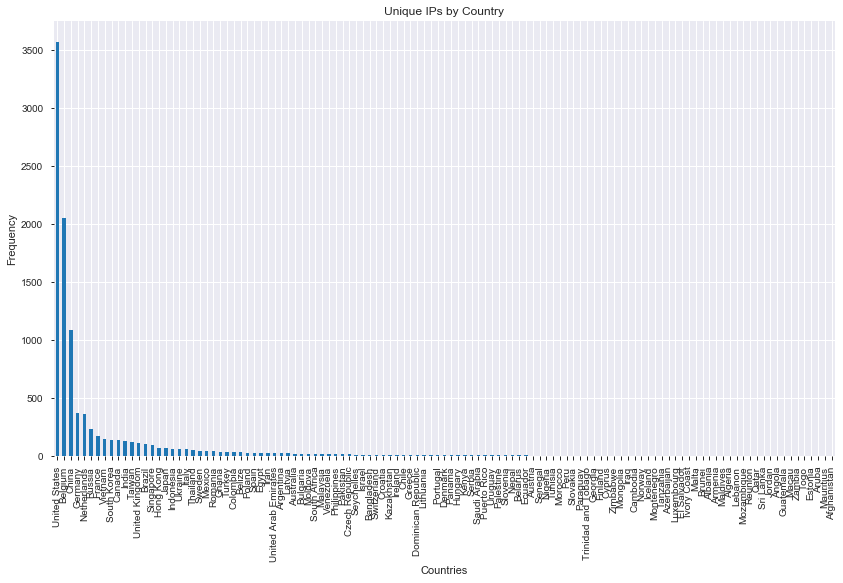

In [29]:
ax = grey_noise_loc['metadata.country'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Unique IPs by Country")
ax.set_xlabel("Countries")
ax.set_ylabel("Frequency")
plt.show()

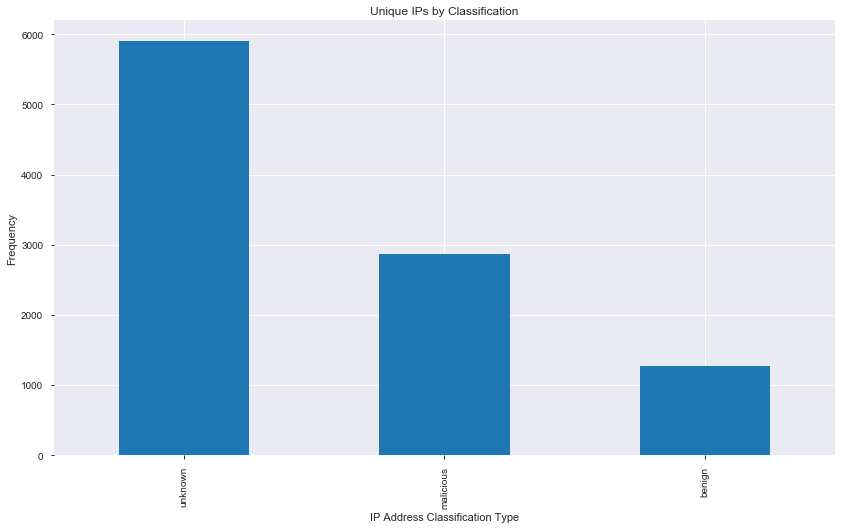

In [30]:
ax = grey_noise_loc['classification'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Unique IPs by Classification")
ax.set_xlabel("IP Address Classification Type")
ax.set_ylabel("Frequency")
plt.show()